# Machine Learning Model Training and Evaluation

This notebook implements multiple regression models and evaluates their performance using various metrics.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor

In [2]:
# Load and examine the data
df = pd.read_csv("stud.csv")
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nColumns in the dataset:")
print(df.columns.tolist())
print("\nDataset information:")
df.info()


First few rows of the dataset:
   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Columns in the dataset:
['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_

In [3]:
# Create total score by combining math, reading, and writing scores
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']

print("\nFirst few rows with total score:")
print(df.head())
print("\nSummary statistics of total score:")
print(df['total_score'].describe())


First few rows with total score:
   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  \
0                    none          72             72             74   
1               completed          69             90             88   
2                    none          90             95             93   
3                    none          47             57             44   
4                    none          76             78             75   

   total_score  
0          218  
1          247  
2          278  
3          148  
4          229  

Summary statist

In [4]:
# Let's examine the structure of our dataset
print("Column names in the dataset:")
print(df.columns.tolist())
print("\nDataset Info:")
df.info()

Column names in the dataset:
['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score', 'total_score']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
 8   total_score                  1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [10]:
# Data preprocessing function
def preprocess_data(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Fit and transform the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor

# Model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_adj_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    
    # Calculate metrics for test data
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_adj_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    
    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_adj_r2': train_adj_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_adj_r2': test_adj_r2
    }

In [11]:
# Prepare your data
# Using math_score as target variable and using other features
y = df['math_score']
X = df.drop(['math_score'], axis=1)  # Keep reading and writing scores as features

# Preprocess the data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=False),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

# Dictionary to store results
results = {}

In [12]:
# Train and evaluate all models
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Preprocess data first
    X_train_processed, X_test_processed, y_train, y_test, preprocessor = preprocess_data(X, y)
    # Evaluate model
    results[name] = evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)
    
# Create a comparison dataframe
comparison_df = pd.DataFrame(results).T
metrics = ['test_r2', 'test_rmse', 'test_mae', 'train_r2', 'train_rmse', 'train_mae']
comparison_df = comparison_df[metrics]

# Display results
print("\nModel Performance Comparison:")
print(comparison_df)

# Find the best models based on test R2 score
best_models = comparison_df.nlargest(2, 'test_r2')
print("\nBest performing models based on Test R2 Score:")
print(best_models[['test_r2', 'test_rmse', 'test_mae']])


Training Linear Regression...

Training Lasso...

Training Ridge...

Training KNN...

Training Decision Tree...

Training Random Forest...

Training Decision Tree...

Training Random Forest...

Training XGBoost...

Training CatBoost...

Training XGBoost...

Training CatBoost...

Training AdaBoost...

Model Performance Comparison:
                    test_r2     test_rmse      test_mae  train_r2  \
Linear Regression  1.000000  1.371458e-13  1.074341e-13  1.000000   
Lasso              0.908665  4.714376e+00  3.756158e+00  0.900530   
Ridge              0.998918  5.130181e-01  4.008033e-01  0.998860   
KNN                0.860098  5.834689e+00  4.488000e+00  0.903275   
Decision Tree      0.944686  3.668787e+00  2.830000e+00  1.000000   
Random Forest      0.962415  3.024204e+00  2.137350e+00  0.994378   
XGBoost            0.974860  2.473351e+00  1.765203e+00  0.999914   
CatBoost           0.963509  2.979893e+00  2.013397e+00  0.995675   
AdaBoost           0.926480  4.229689e+00  3.3

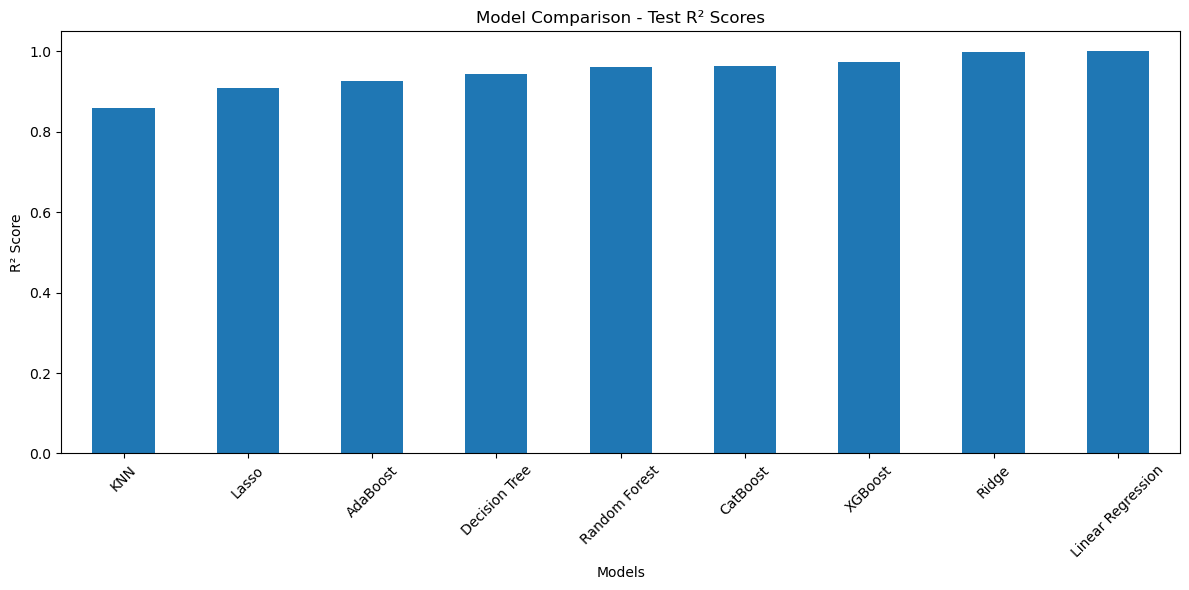

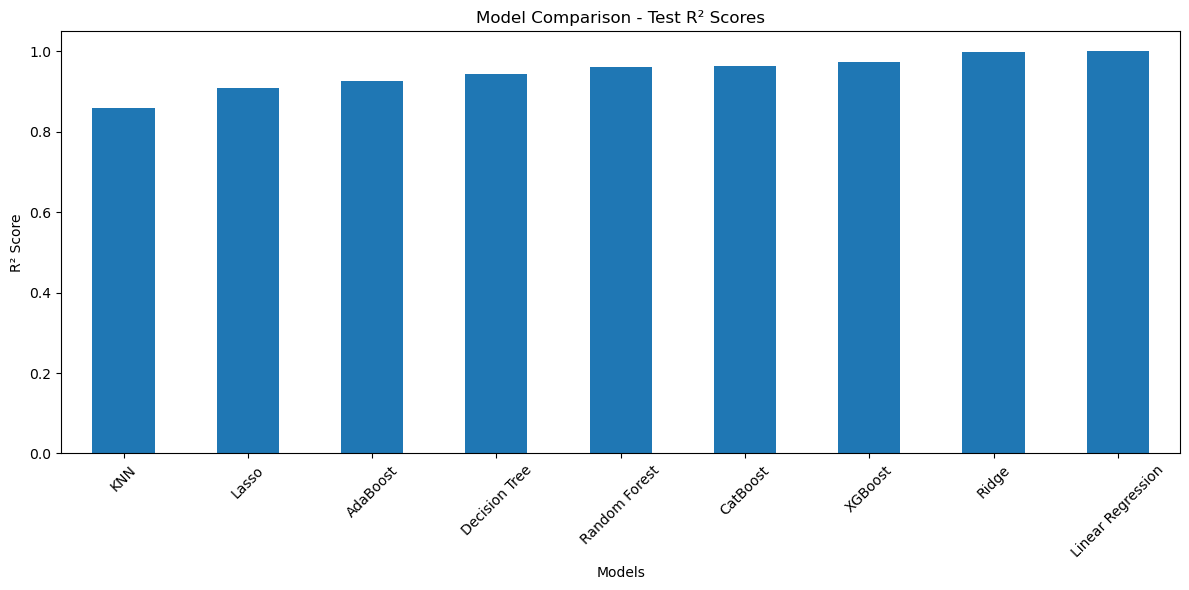

<Figure size 1200x600 with 0 Axes>

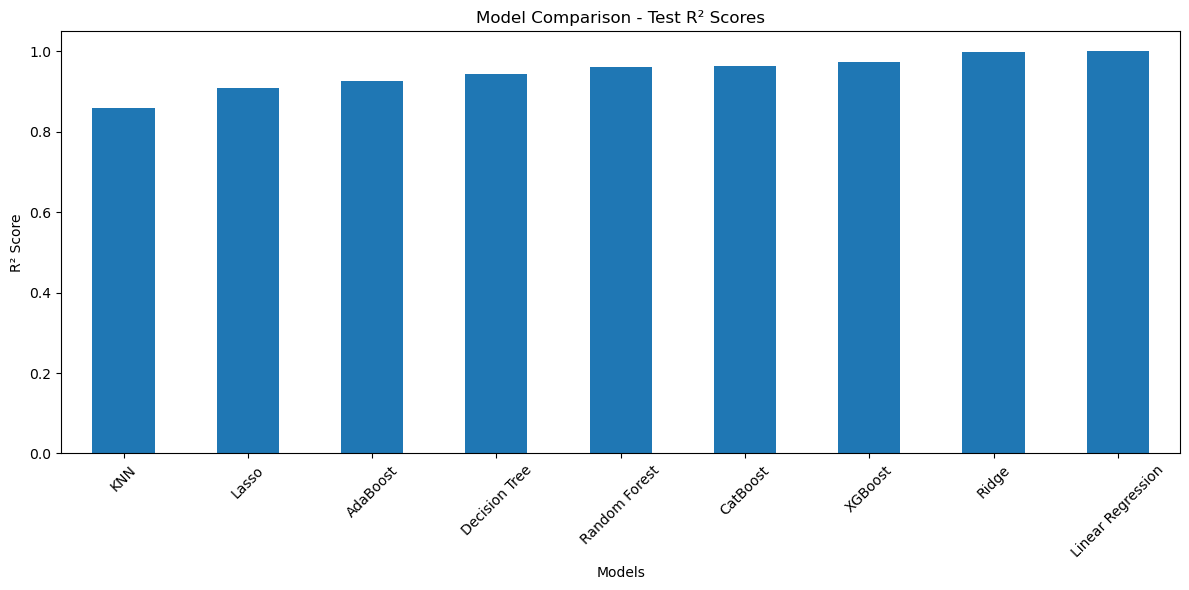

<Figure size 1200x600 with 0 Axes>

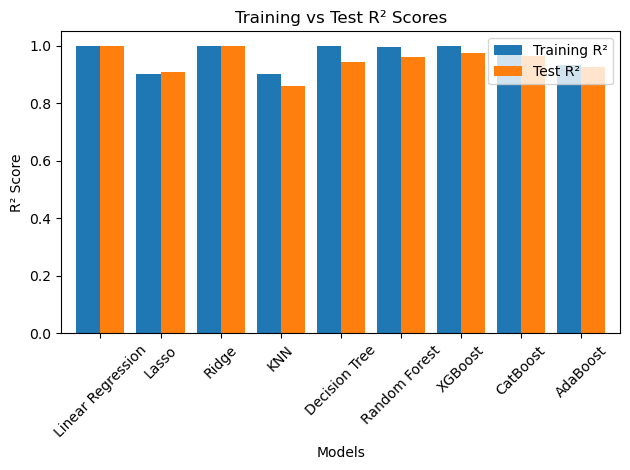

In [13]:
# Visualize model performance
plt.figure(figsize=(12, 6))
comparison_df['test_r2'].sort_values().plot(kind='bar')
plt.title('Model Comparison - Test R² Scores')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize training vs test performance
plt.figure(figsize=(12, 6))
comparison_df[['train_r2', 'test_r2']].plot(kind='bar', width=0.8)
plt.title('Training vs Test R² Scores')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.legend(['Training R²', 'Test R²'])
plt.tight_layout()
plt.show()